# 1.import 

In [ ]:
%autosave 300

Autosaving every 300 seconds


In [158]:
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

     |████████████████████████████████| 965 kB 5.1 MB/s 


In [129]:
import os
import pandas as pd
import tensorflow as tf
from google.colab import drive # only import when run in colab
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SpatialDropout1D,LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
import spacy
import numpy as np
from spacy import displacy
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

drive.mount('/content/drive')
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))
print('package import complete')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tensorflow version: 2.8.0
GPU detected: []
package import complete


In [194]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector   
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


# **2.read data**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/6.git_cloned/tutorial/my tutorrial/data/ner_dataset.csv', encoding= 'unicode_escape')
data.head(2)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O


In [ ]:
data.shape

(1048575, 4)

We can see that the sentences are broken into tokens in the column 'Word'. The column 'sentence #' displays the sentence number once and then prints NaN till the next sentence begins.

# ***3.data processing***

## 3.1. Extract mappings required for the neural network
To train a neural network, we will use two mappings as given below. The neural network will only take integers as input. So lets convert all the unique tokens in the corpus to its respective index.
- {token} to {token id}: address the row in embeddings matrix for the current token.
- {tag} to {tag id}: one-hot ground truth probability distribution vectors for computing the loss at the output of the network.

In [ ]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [ ]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx) 

In [ ]:
data.head(2)

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,24370,10
1,NaN,of,IN,O,30026,10


## 3.2 Transform columns to extract sequential data
Next, lets fill NaN in 'sentence #' column using method ffill in fillna. Thereafter groupby on the sentence column to get a list of tokens and tags for each sentence.

In [ ]:
data.isna().any()

Sentence #     True
Word          False
POS           False
Tag           False
Word_idx      False
Tag_idx       False
dtype: bool

In [ ]:
data_fillna = data.fillna(method='ffill', axis=0)
data_group = data_fillna.groupby(['Sentence #'],as_index=False
                                )['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

data_group.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[24370, 30026, 30115, 35106, 20651, 20751, 910...","[10, 10, 10, 10, 10, 10, 4, 10, 10, 10, 10, 10..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[22631, 31182, 17797, 30379, 32284, 5394, 2497...","[1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[33036, 23410, 33502, 1663, 358, 33280, 5165, ...","[10, 10, 16, 10, 10, 10, 10, 10, 4, 10, 10, 10..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[9984, 25605, 18476, 15779, 11537, 12574, 1781...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[32299, 12442, 28827, 22578, 15197, 10431, 345...","[4, 10, 10, 0, 14, 10, 16, 10, 4, 10, 1, 10, 1..."


## 3.3 Pad sequences and split the dataset into train, test
Padding: The LSTM layers accept sequences of same length only. Therefore we will want to transform our list of token_sequences ('Word_idx') which is lists of integers into a matrix of shape (token_sequences, max_len). We can use any length as max_len. In this project we will be using length of the longest sequence as max_len. The sequences that are shorter than max_len are padded with a specified value at the end.
Import required packages

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [20]:
def get_pad_train_test_val(data_group, data):
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))
    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)
    
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    
    train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ntest_tags:', len(test_tags)
    )
    
    return train_tokens, test_tokens, train_tags, test_tags

x_train, x_test, y_train, y_test = get_pad_train_test_val(data_group, data)

train_tokens length: 43163 
test_tokens length: 4796 
train_tags: 43163 
test_tags: 4796


In [ ]:
np.array(train_tags).shape

(43163, 104, 17)

## 3.4 processing for v3 model only

In [117]:
data = data.fillna(method="ffill")
data.head(5)

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,24370,10
1,Sentence: 1,of,IN,O,30026,10
2,Sentence: 1,demonstrators,NNS,O,30115,10
3,Sentence: 1,have,VBP,O,35106,10
4,Sentence: 1,marched,VBN,O,20651,10


In [119]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)
tags = list(set(data["Tag"].values))
num_tags = len(tags)
print(num_words, num_tags)


35179 17


In [120]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [121]:
getter = SentenceGetter(data)


In [122]:
sentences = getter.sentences
sentences[0]



[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [123]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [124]:
max_len = 50
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [125]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [126]:
print(x_train.shape,y_train.shape)

(38367, 50) (38367, 50)


In [127]:
y_train

array([[10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       ...,
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10,  1, ..., 10, 10, 10]], dtype=int32)

#4.Build Model Layout






In [ ]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  35179 
output_dim:  64 
input_length:  104 
n_tags:  17


## 4.1 v1

In [44]:
def lstm_model_v1():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    
    return model

In [45]:
  loss = []
  model = lstm_model_v1()
  model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 104, 64)           2251456   
                                                                 
 bidirectional_10 (Bidirecti  (None, 104, 128)         66048     
 onal)                                                           
                                                                 
 lstm_21 (LSTM)              (None, 104, 64)           49408     
                                                                 
 time_distributed_10 (TimeDi  (None, 104, 17)          1105      
 stributed)                                                      
                                                                 
Total params: 2,368,017
Trainable params: 2,368,017
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_10"
____________________

In [46]:
for _ in range(5):
        # fit model for one epoch on this sequence
      hist = model.fit(x_train, np.array(y_train),
                       batch_size=64, 
                       verbose=1, epochs=1,
                       validation_data=(x_test, np.array(y_test)))
      loss.append(hist.history['loss'][0])

675/675 [==============================] - 464s 687ms/step - loss: 0.1527 - accuracy: 0.9678 - val_loss: 0.1375 - val_accuracy: 0.9680


##4.2 v2

In [62]:
def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad tokens (X var)    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    tokens_, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags)
    )
    return train_tokens, test_tokens, train_tags, test_tags

train_tokens, test_tokens, train_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 43163 
train_tokens length: 43163 
test_tokens length: 4796 
test_tags: 4796


In [63]:
train_tags = np.array(train_tags)
test_tags = np.array(test_tags)
print('train_tags: ',train_tags.shape,'test_tags: ',test_tags.shape)


train_tags:  (43163, 104, 17) test_tags:  (4796, 104, 17)


In [71]:
train_label = np.argmax(train_tags, axis=-1)
test_label = np.argmax(test_tags,axis=-1)
print(train_tokens.shape)
print(train_label.shape)

(43163, 104)
(43163, 104)


In [74]:
train_label[0]

array([10, 10,  0, 10, 10, 10, 10, 10, 10,  4, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 16,  8,  8, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10])

In [64]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)

In [65]:
def lstm_model_v2():
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.22))
    model.add((Dense(n_tags, activation="softmax")))
    opt = keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    
    return model

In [73]:
model2 = lstm_model_v2()
model2

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 104, 64)           2251456   
                                                                 
 bidirectional_12 (Bidirecti  (None, 104, 128)         66048     
 onal)                                                           
                                                                 
 lstm_25 (LSTM)              (None, 104, 64)           49408     
                                                                 
 dense_12 (Dense)            (None, 104, 17)           1105      
                                                                 
Total params: 2,368,017
Trainable params: 2,368,017
Non-trainable params: 0
_________________________________________________________________


In [75]:
history = model2.fit(train_tokens, train_label ,
                    batch_size = 64, epochs=5,
                    validation_data=(test_tokens, test_label)) 

Epoch 1/5
675/675 [==============================] - 472s 684ms/step - loss: 0.4152 - accuracy: 0.9632 - val_loss: 0.1664 - val_accuracy: 0.9680
Epoch 2/5
675/675 [==============================] - 461s 683ms/step - loss: 0.1619 - accuracy: 0.9678 - val_loss: 0.1519 - val_accuracy: 0.9680
Epoch 3/5
675/675 [==============================] - 461s 683ms/step - loss: 0.1409 - accuracy: 0.9678 - val_loss: 0.1195 - val_accuracy: 0.9680
Epoch 4/5
675/675 [==============================] - 457s 676ms/step - loss: 0.1027 - accuracy: 0.9703 - val_loss: 0.0838 - val_accuracy: 0.9748
Epoch 5/5
675/675 [==============================] - 457s 677ms/step - loss: 0.0776 - accuracy: 0.9763 - val_loss: 0.0710 - val_accuracy: 0.9774


##4.3 v3

In [130]:
def lstm_model_v3():
  input_word = Input(shape=(max_len,))
  model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
  model = SpatialDropout1D(0.1)(model)
  model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
  out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
  model = Model(input_word, out)
  model.summary()
  return model
model3 = lstm_model_v3()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_14 (Embedding)    (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional_13 (Bidirecti  (None, 50, 200)          120800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 50, 17)           3417      
 stributed)                                                      
                                                             

In [134]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

model3.compile(optimizer=opt,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history = model3.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
)

Epoch 1/3
1199/1199 [==============================] - 257s 209ms/step - loss: 0.4695 - accuracy: 0.9286 - val_loss: 0.3008 - val_accuracy: 0.9337
Epoch 2/3
1199/1199 [==============================] - 247s 206ms/step - loss: 0.2382 - accuracy: 0.9365 - val_loss: 0.1863 - val_accuracy: 0.9450
Epoch 3/3
1199/1199 [==============================] - 248s 207ms/step - loss: 0.1636 - accuracy: 0.9491 - val_loss: 0.1473 - val_accuracy: 0.9540


In [ ]:
# 

# 5.evaluation and save

## 5.1 save model

In [48]:
# save v1
tf.keras.models.save_model(model, filepath  = "/content/drive/MyDrive/6.git_cloned/tutorial/my tutorrial/model/ner_bilstm_v1.h5")

In [76]:
# save v2
tf.keras.models.save_model(model2,model_path+ '/ner_bilstm_v2.h5')

## 5.2 load model

In [49]:
# load v1
model_path = '/content/drive/MyDrive/6.git_cloned/tutorial/my tutorrial/model/'
model = tf.keras.models.load_model(model_path + '/ner_bilstm_v1.h5')


In [77]:
# load v2
model2 = tf.keras.models.load_model(model_path + '/ner_bilstm_v2.h5')

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

## 5.3 evaluate

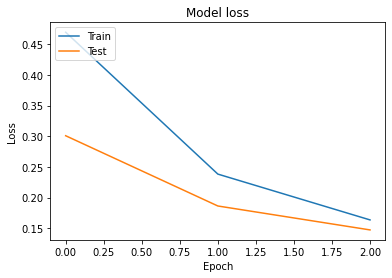

In [137]:
# v3

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [79]:

y_test = np.argmax(test_tags, axis=-1)
print(test_tokens.shape,y_test.shape)
model2.evaluate(test_tokens, y_test)

(4796, 104) (4796, 104)
150/150 [==============================] - 18s 109ms/step - loss: 0.0710 - accuracy: 0.9774


[0.07101599872112274, 0.9774090647697449]

# 6.prediction

##6.1 v2 preidction

In [81]:
# def predict(seed,model):
#     query  = test_tokens[seed]
#     query_text = []
#     for i in query.tolist():
#         query_text.append(idx2token.get(i))
#     print('Query_Text: ',' '.join(query_text[:10]))

#     ans = y_test[seed]
#     ans_text = []
#     for i in ans.tolist():
#         ans_text.append(idx2tag.get(i))
#     print('Tag_Text: ',' '.join(ans_text[:10]))

#     query = query.reshape(1,-1)
#     pred = model.predict(query)
#     pred = np.ravel(np.argmax(pred, axis=-1))
#     print('Query: ',query.shape,'Prediction: ',pred.shape)

#     pred_list = []
#     for i in pred.tolist():
#         pred_list.append(idx2tag.get(i))
#     print('Prediction_Text: ',' '.join(pred_list[:10])) 
#     print()
#     print('--- Better-Representation---')
#     print()
#     rep_qr = []
#     for q, r_tag in zip(query_text[:10], ans_text[:10]):
#         rep_qr.append(q)
#         rep_qr.append('['+r_tag+']')
#     print('Actual_NER: ',' '.join(rep_qr),'....')
#     print()
#     rep_qp = []
#     for q, r_tag in zip(query_text[:10], pred_list[:10]):
#         rep_qp.append(q)
#         rep_qp.append('['+r_tag+']')
#     print('--'*70)
#     print()
#     print('Predicted_NER: ',' '.join(rep_qp),'....')

# seed = 1
# predict(seed,model2)

Query_Text:  A spokesman says he expects the Tibetan leader to return
Tag_Text:  O O O O O O B-gpe O O O
Query:  (1, 104) Prediction:  (104,)
Prediction_Text:  O O O O O O B-geo O O O

--- Better-Representation---

Actual_NER:  A [O] spokesman [O] says [O] he [O] expects [O] the [O] Tibetan [B-gpe] leader [O] to [O] return [O] ....

--------------------------------------------------------------------------------------------------------------------------------------------

Predicted_NER:  A [O] spokesman [O] says [O] he [O] expects [O] the [O] Tibetan [B-geo] leader [O] to [O] return [O] ....


## 6.2 v3 preidiction

In [138]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model3.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
In             O	O
December       B-tim	B-geo
,              O	O
the            O	O
U.N.           B-org	B-org
Security       I-org	I-org
Council        I-org	I-per
passed         O	O
economic       O	O
sanctions      O	O
against        O	O
Iran           B-geo	B-geo
for            O	O
its            O	O
controversial  O	O
nuclear        O	O
enrichment     O	O
program        O	O
.              O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepers     O	O
zookeepe

In [206]:
p = model3.predict(np.array(x_test))
yhat = np.argmax(p, axis=-1)
y = y_test

In [170]:

classes = np.unique(data.Tag.values)
classes = classes.tolist()
new_classes = classes.copy()
new_classes.pop()
new_classes

['B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim']

In [207]:
yhat

array([[10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       ...,
       [ 4, 10, 10, ..., 10, 10, 10],
       [10,  4, 14, ..., 10, 10, 10],
       [10, 10,  5, ..., 10, 10, 10]])

In [177]:
def create_label_class_dictionary(data, column):
    # create_label_class_dictionary(df, "label")
    '''dictionary for text class with interger number
    data: data file
    column: column name in the data file: must be string format
    '''
    
    dtf = data
    dtf[column+"_id"] = dtf[column].factorize(sort=True)[0]
    dic_class_mapping = dict( dtf[[column+"_id",column]].drop_duplicates().sort_values(column+"_id").values )
    return dtf, dic_class_mapping
data, dic_y_mapping = create_label_class_dictionary(data, "Tag")

In [210]:
y.shape,yhat.shape

((9592, 50), (9592, 50))

In [214]:
from sklearn.metrics import classification_report


(479600,)

In [218]:
y[32]

array([16, 10, 10, 10, 10, 10, 10, 10, 10,  5,  6,  6,  6, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
      dtype=int32)